In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scores2/scores.csv
/kaggle/input/images/167__M_Left_thumb_finger.jpg
/kaggle/input/images/189__F_Left_ring_finger.jpg
/kaggle/input/images/187__M_Right_index_finger.jpg
/kaggle/input/images/180__F_Right_middle_finger.jpg
/kaggle/input/images/181__M_Right_index_finger.jpg
/kaggle/input/images/186__M_Right_middle_finger.jpg
/kaggle/input/images/15__F_Left_thumb_finger.jpg
/kaggle/input/images/116__M_Right_ring_finger.jpg
/kaggle/input/images/158__M_Right_index_finger.jpg
/kaggle/input/images/108__M_Left_middle_finger.jpg
/kaggle/input/images/153__M_Right_thumb_finger.jpg
/kaggle/input/images/167__M_Right_ring_finger.jpg
/kaggle/input/images/179__M_Right_middle_finger.jpg
/kaggle/input/images/185__M_Right_little_finger.jpg
/kaggle/input/images/132__M_Left_ring_finger.jpg
/kaggle/input/images/173__F_Left_little_finger.jpg
/kaggle/input/images/187__M_Right_thumb_finger.jpg
/kaggle/input/images/108__M_Right_middle_finger.jpg
/kaggle/input/images/110__F_Left_little_finger.jpg
/k

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, GaussianBlur, Normalize
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision.models import resnext50_32x4d
from torchvision.models import vgg16
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Paths
image_folder = "/kaggle/input/images"  # Replace with your image folder path
csv_file = "/kaggle/input/scores2/scores.csv"  # Replace with your CSV file path

# Load labels CSV
df = pd.read_csv(csv_file)
df.set_index("Image Name", inplace=True)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Augmentation pipeline with Resize
augmentation = Compose([
    Resize(224, 224),  # Resize all images to 224x224
    HorizontalFlip(p=0.5),  # Random horizontal flip
    VerticalFlip(p=0.5),  # Random vertical flip
    Rotate(limit=30, p=0.5),  # Random rotation (-30 to 30 degrees)
    Normalize(mean=[0.5], std=[0.5]),  # Normalize for grayscale images
    ToTensorV2()
])

# Function to preprocess and augment image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode)
    image = augmentation(image=np.array(image))  # Apply augmentations and resizing
    return image
# Example Dataset Processing
processed_images = []
labels = []

for filename in os.listdir("/kaggle/input/images"):
        image_path = os.path.join("/kaggle/input/images", filename)
        try:
            processed_image = preprocess_image(image_path)
            label = df.loc[filename, "Score"]  # Fetch score from CSV

            processed_images.append(processed_image)
            labels.append(label)

            print(f"Processed: {filename}, Score: {label}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert to PyTorch Tensors for Training
if len(processed_images) > 0:
    X = torch.stack([img["image"] for img in processed_images])  # Images
    y = torch.tensor(labels, dtype=torch.float32)  # Labels
else:
    raise RuntimeError("No valid images were processed!")

print("Preprocessing complete! Ready for training.")

Processed: 167__M_Left_thumb_finger.jpg, Score: 1
Processed: 189__F_Left_ring_finger.jpg, Score: 2
Processed: 187__M_Right_index_finger.jpg, Score: 2
Processed: 180__F_Right_middle_finger.jpg, Score: 3
Processed: 181__M_Right_index_finger.jpg, Score: 2
Processed: 186__M_Right_middle_finger.jpg, Score: 0
Processed: 15__F_Left_thumb_finger.jpg, Score: 2
Processed: 116__M_Right_ring_finger.jpg, Score: 3
Processed: 158__M_Right_index_finger.jpg, Score: 0
Processed: 108__M_Left_middle_finger.jpg, Score: 2
Processed: 153__M_Right_thumb_finger.jpg, Score: 2
Processed: 167__M_Right_ring_finger.jpg, Score: 2
Processed: 179__M_Right_middle_finger.jpg, Score: 1
Processed: 185__M_Right_little_finger.jpg, Score: 3
Processed: 132__M_Left_ring_finger.jpg, Score: 2
Processed: 173__F_Left_little_finger.jpg, Score: 1
Processed: 187__M_Right_thumb_finger.jpg, Score: 3
Processed: 108__M_Right_middle_finger.jpg, Score: 1
Processed: 110__F_Left_little_finger.jpg, Score: 2
Processed: 15__F_Right_thumb_finger

In [ ]:
# Define dataset class
class FingerprintDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Check if '.jpg' is already included in the filename
        filename = self.df.iloc[idx]["Image Name"]
        if not filename.endswith(".jpg"):
            filename += ".jpg"  # Append '.jpg' only if missing

        img_name = os.path.join(self.image_folder, filename)

        # Open the image file
        image = Image.open(img_name).convert("L")  # Convert to grayscale, use "L" if needed

        label = torch.tensor(self.df.iloc[idx]["Score"], dtype=torch.long)  # Classification (0-4)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is 1 channel (grayscale)
    transforms.Resize((224, 224)),  # Resize to consistent dimensions
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale input
])
dataset = FingerprintDataset(csv_file, image_folder, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

RESNEXT NEURAL NETWORK

In [ ]:
# Define the custom model
class ExtendedResNeXt(nn.Module):
    def __init__(self, num_classes=5):
        super(ExtendedResNeXt, self).__init__()
        self.base_model = resnext50_32x4d(pretrained=True)

        # Modify the first convolutional layer to accept grayscale input
        self.base_model.conv1 = nn.Conv2d(
            in_channels=1,  # Change input channels to 1 for grayscale
            out_channels=64,  # Keep output channels the same
            kernel_size=7,  # Original kernel size
            stride=2,  # Original stride
            padding=3,  # Original padding
            bias=False  # Original bias setting
        )

        # Remove the original classification head
        self.base_model.fc = nn.Identity()

        # Add custom layers after the base model
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 512),  # Input matches ResNeXt's output features
            nn.ReLU(),  # Activation function
            nn.Dropout(p=0.3),  # Dropout
            nn.Linear(512, 256),  # Second dense layer
            nn.ReLU(),  # Activation
            nn.Linear(256, 256),
            nn.Softmax(),
            nn.Linear(256, num_classes)# Final classification layer
        )

    def forward(self, x):
        x = self.base_model(x)  # Extract features from ResNeXt
        x = self.fc_layers(x)  # Pass through custom layers
        return x

# Instantiate the model
model = ExtendedResNeXt(num_classes=5)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define Early Stopping variables
best_loss = float("inf")  # Initialize with infinity
patience = 5  # Number of epochs to wait before stopping
counter = 0  # Counter to track epochs without improvement

num_epochs = 100
all_labels = []  # Store true labels (only for the last epoch)
all_predictions = []  # Store predicted labels (only for the last epoch)
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    total = 0  # Total number of examples
    correct = 0  # Total correct predictions
    running_loss = 0.0  # Track loss across batches

    for images, labels in dataloader:
        images, labels = images.to("cuda"), labels.to("cuda")

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for this epoch
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get max log-probability index
        total += labels.size(0)  # Count total labels
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Collect predictions and true labels only in the last epoch
        if epoch == num_epochs - 1:
            all_labels.extend(labels.cpu().numpy())  # Move to CPU for sklearn
            all_predictions.extend(predicted.cpu().numpy())  # Move to CPU for sklearn

    # Compute average loss and accuracy for this epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    # Print epoch loss and accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss  # Update the best loss
        counter = 0  # Reset counter if improvement occurs
    else:
        counter += 1  # Increment counter if no improvement
        print(f"Early Stopping Counter: {counter}/{patience}")

    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

# Generate classification report (only after last epoch)
if all_labels and all_predictions:
    report = classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(5)])
    print("\nFinal Classification Report:\n", report)

Epoch [1/100], Loss: 1.5883, Accuracy: 28.20%
Epoch [2/100], Loss: 1.5746, Accuracy: 28.20%
Epoch [3/100], Loss: 1.5640, Accuracy: 28.20%
Epoch [4/100], Loss: 1.5530, Accuracy: 28.20%
Epoch [5/100], Loss: 1.5442, Accuracy: 28.20%
Epoch [6/100], Loss: 1.5381, Accuracy: 28.20%
Epoch [7/100], Loss: 1.5321, Accuracy: 28.20%
Epoch [8/100], Loss: 1.5280, Accuracy: 28.20%
Epoch [9/100], Loss: 1.5224, Accuracy: 28.20%
Epoch [10/100], Loss: 1.5207, Accuracy: 28.20%
Epoch [11/100], Loss: 1.5156, Accuracy: 28.20%
Epoch [12/100], Loss: 1.5160, Accuracy: 28.20%
Early Stopping Counter: 1/5
Epoch [13/100], Loss: 1.5087, Accuracy: 28.20%
Epoch [14/100], Loss: 1.5117, Accuracy: 28.20%
Early Stopping Counter: 1/5
Epoch [15/100], Loss: 1.5048, Accuracy: 28.20%
Epoch [16/100], Loss: 1.5090, Accuracy: 28.20%
Early Stopping Counter: 1/5
Epoch [17/100], Loss: 1.5037, Accuracy: 28.20%
Epoch [18/100], Loss: 1.5011, Accuracy: 28.20%
Epoch [19/100], Loss: 1.5012, Accuracy: 28.20%
Early Stopping Counter: 1/5
Epoc

VGG-16 ARCHITECTURE

In [ ]:
import torch
from torchvision.models import vgg16
import torch.nn as nn

class ExtendedVGG(nn.Module):
    def __init__(self, num_classes=5):
        super(ExtendedVGG, self).__init__()
        self.base_model = vgg16(pretrained=True)

        # Modify the first convolutional layer to accept grayscale input
        self.base_model.features[0] = nn.Conv2d(
            in_channels=1,  # Change input channels to 1 for grayscale
            out_channels=64,  # Keep output channels the same
            kernel_size=3,  # Original kernel size
            stride=1,  # Original stride
            padding=1,  # Original padding
            bias=False  # Original bias setting
        )

        # Remove the original classifier
        self.base_model.classifier = nn.Identity()

        # Dynamically calculate the feature map size
        self.feature_map_size = self._get_feature_map_size()

        # Add custom fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_map_size, 512),  # Use dynamic feature map size
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Final classification layer
        )

    def _get_feature_map_size(self):
        # Pass a dummy input through the feature extractor to determine the feature map size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)  # Batch size 1, grayscale image (1 channel)
            feature_map = self.base_model.features(dummy_input)
            return feature_map.view(1, -1).size(1)  # Flatten and get the total size

    def forward(self, x):
        x = self.base_model.features(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.fc_layers(x)  # Pass through fully connected layers
        return x

model = ExtendedVGG(num_classes=5)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/150], Loss: 2.1192, Accuracy: 25.10%
Epoch [2/150], Loss: 1.5192, Accuracy: 25.90%
Epoch [3/150], Loss: 1.5015, Accuracy: 26.10%
Epoch [4/150], Loss: 1.5261, Accuracy: 26.70%
Epoch [5/150], Loss: 1.4899, Accuracy: 29.60%
Epoch [6/150], Loss: 1.4920, Accuracy: 27.10%
Epoch [7/150], Loss: 1.5047, Accuracy: 27.30%
Epoch [8/150], Loss: 1.5110, Accuracy: 27.10%
Epoch [9/150], Loss: 1.4892, Accuracy: 29.40%
Epoch [10/150], Loss: 1.4683, Accuracy: 30.30%
Epoch [11/150], Loss: 1.4944, Accuracy: 31.20%
Epoch [12/150], Loss: 1.5025, Accuracy: 29.10%
Epoch [13/150], Loss: 1.4943, Accuracy: 30.40%
Epoch [14/150], Loss: 1.4586, Accuracy: 32.10%
Epoch [15/150], Loss: 1.4865, Accuracy: 34.10%
Epoch [16/150], Loss: 1.4266, Accuracy: 32.90%
Epoch [17/150], Loss: 1.4596, Accuracy: 32.00%
Epoch [18/150], Loss: 1.4913, Accuracy: 32.70%
Epoch [19/150], Loss: 1.4212, Accuracy: 36.30%
Epoch [20/150], Loss: 1.3315, Accuracy: 40.50%
Epoch [21/150], Loss: 1.3531, Accuracy: 37.90%
Epoch [22/150], Loss: 

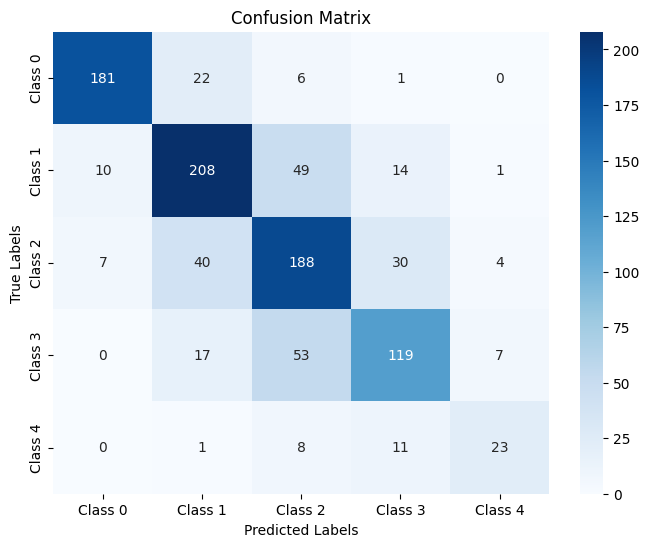

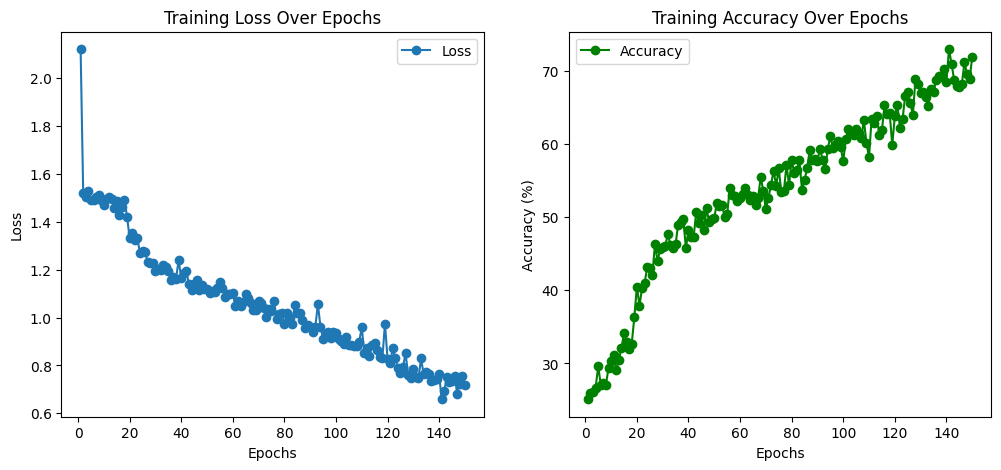

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  # For better visualization of the confusion matrix

# Initialize lists to store loss and accuracy values
epoch_losses = []
epoch_accuracies = []

num_epochs = 150
all_labels = []  # Store true labels (only for the last epoch)
all_predictions = []  # Store predicted labels (only for the last epoch)

for epoch in range(num_epochs):
    total = 0  # Total number of examples
    correct = 0  # Total correct predictions
    running_loss = 0.0  # Track loss across batches

    for images, labels in dataloader:
        images, labels = images.to("cuda"), labels.to("cuda")

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for this epoch
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get max log-probability index
        total += labels.size(0)  # Count total labels
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Collect predictions and true labels only in the last epoch
        if epoch == num_epochs - 1:
            all_labels.extend(labels.cpu().numpy())  # Move to CPU for sklearn
            all_predictions.extend(predicted.cpu().numpy())  # Move to CPU for sklearn

    # Compute average loss and accuracy for this epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    # Print epoch loss and accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Generate classification report (only after last epoch)
report = classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(5)])
print("\nFinal Classification Report:\n", report)

# Generate confusion matrix (only after last epoch)
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker="o", label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker="o", color="green", label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.show()